In [1]:
import pandas as pd
from utils import data_wrangling as dw
from utils import ts_wrangling as tw
from models import autoarima_model as am
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    CrostonOptimized,
    TSB,
    MSTL,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
)

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
INIT = "2012-01-01"
END = "2023-02-28"
PERIOD = 24*365
HORIZON = 24*2

# Dados

In [3]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-03-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [4]:
df_load.describe()

,load_mwmed
count,8760.000000
mean,11641.760189
std,2295.359889
min,5755.558000
25%,9782.649250
50%,11768.670030
75%,13344.280750
max,18345.403000


In [5]:
train, test = tw.train_test_split(df_load, test=HORIZON)

# Modelos

In [23]:
df_fc = am.auto_arima_model(df=train, h_=HORIZON)

In [29]:
df_fc.head()

,ds,AutoARIMA
unique_id,,
hourly_load,2023-02-27 00:00:00,10583.355469
hourly_load,2023-02-27 01:00:00,10007.152344
hourly_load,2023-02-27 02:00:00,9638.824219
hourly_load,2023-02-27 03:00:00,9451.693359
hourly_load,2023-02-27 04:00:00,9384.501953


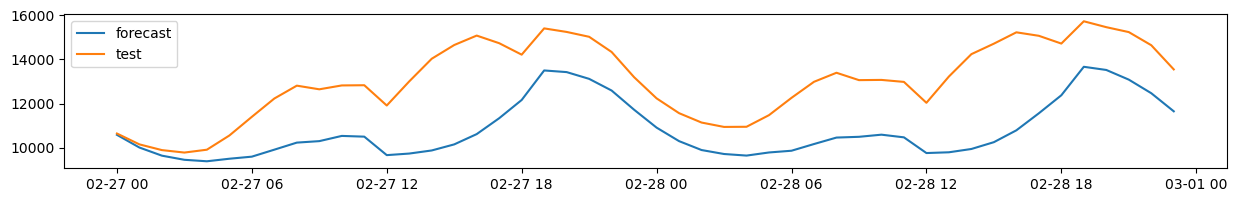

In [36]:
plt.figure(figsize=(15,2))
plt.plot(df_fc.ds, df_fc.AutoARIMA, label="forecast")
plt.plot(test.index, test.load_mwmed, label="test")
plt.legend()
plt.show()

In [ ]:
forecasts_df = sf.forecast(h=48, level=[90])

# Comparação de modelos

In [6]:
df_sf = dw.prepare_statsforecast_df(train, "hourly_load")

In [30]:
models = [
    AutoARIMA(season_length=24),
    #HoltWinters(), #erro: nonseasonal
    Croston(),
    CrostonOptimized(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    #TSB(),
    MSTL(season_length=[24, 24*7]),
    HistoricAverage(),
    AutoETS(),
    AutoCES(),
    AutoTheta()
]

In [31]:
sf = StatsForecast(
    df=df_sf, 
    models=models,
    freq='H', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=24)
)

In [32]:
sf.fit(df_sf)

StatsForecast(models=[AutoARIMA,CrostonClassic,CrostonOptimized,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,MSTL,HistoricAverage,AutoETS,CES,AutoTheta])

In [33]:
forecasts_df = sf.forecast(h=48, level=[99, 95, 90])

forecasts_df.head()